In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import warnings
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

from quantnn.qrnn import QRNN
from quantnn.models.pytorch import BatchedDataset
from quantnn.models.pytorch.logging import TensorBoardLogger

from models.singles_fc import Net

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device:  cpu


In [2]:
# SETUP
channels = [8, 13]
fillvalue = -1

n_epochs = 20
BATCH_SIZE = 16

quantiles = np.linspace(0.01, 0.99, 99)


In [3]:
path_to_data = 'data/first_net_dataset/singles/'
X_train = np.load(path_to_data+'train/X_singles_dataset.npy')
y_train = np.load(path_to_data+'train/y_singles_dataset.npy')
X_val = np.load(path_to_data+'validation/X_singles_dataset.npy')
y_val = np.load(path_to_data+'validation/y_singles_dataset.npy')

In [4]:
subs = 100000
X_train = X_train[:subs].astype(np.float32)
y_train = y_train[:subs].astype(np.float32)
X_val = X_val[:subs].astype(np.float32)
y_val = y_val[:subs].astype(np.float32)

In [5]:
def Standardize(X, path_to_data):
    stats = np.load(path_to_data+'train/X_singles_stats.npy')
    return (X-stats[0,:])/stats[1,:]

In [6]:
X_train = Standardize(X_train, path_to_data).astype(np.float32)
X_val = Standardize(X_val, path_to_data).astype(np.float32)

In [7]:
model_fc = Net(len(quantiles), len(channels))
qrnn_fc = QRNN(quantiles=quantiles, model=model_fc)

In [8]:
training_data = BatchedDataset((X_train, y_train), 32)
validation_data = BatchedDataset((X_val, y_val), 32)
optimizer = SGD(model_fc.parameters(), lr=0.1, momentum=0.9)

In [9]:
log_directory = None
logger = TensorBoardLogger(n_epochs, log_directory=log_directory)

In [10]:
n_epochs = 10
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.01)
qrnn_fc.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device=device,
              logger=logger);

n_epochs = 20
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.001)
qrnn_fc.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device=device,
              logger=logger);

n_epochs = 40
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.0001)
qrnn_fc.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device=device,
              logger=logger);

Epoch  1 / 20: train. loss = 0.0741, val. loss = 0.0236, lr. = 0.1000, time = 10.821497 s
Epoch  2 / 20: train. loss = 0.0724, val. loss = 0.0233, lr. = 0.0978, time = 11.617771 s
Epoch  3 / 20: train. loss = 0.0721, val. loss = 0.0234, lr. = 0.0914, time = 11.799776 s
Epoch  4 / 20: train. loss = 0.0719, val. loss = 0.0245, lr. = 0.0815, time = 11.67407 s
Epoch  5 / 20: train. loss = 0.0717, val. loss = 0.0236, lr. = 0.0689, time = 12.204987 s
Epoch  6 / 20: train. loss = 0.0716, val. loss = 0.0234, lr. = 0.0550, time = 12.465506 s
Epoch  7 / 20: train. loss = 0.0715, val. loss = 0.0236, lr. = 0.0411, time = 12.07947 s
Epoch  8 / 20: train. loss = 0.0715, val. loss = 0.0236, lr. = 0.0285, time = 11.953191 s
Epoch  9 / 20: train. loss = 0.0714, val. loss = 0.0233, lr. = 0.0186, time = 12.19803 s
Epoch 10 / 20: train. loss = 0.0714, val. loss = 0.0234, lr. = 0.0122, time = 12.082507 s
Epoch 11 / 20: train. loss = 0.0715, val. loss = 0.0235, lr. = 0.1000, time = 11.929167 s
Epoch 12 / 20

In [11]:
torch.cuda.empty_cache()
validation_data = BatchedDataset((X_val, y_val), 32)

y_true = []
y_pred_fc = []
for x, y in validation_data:
  y_true += [y.detach().numpy()]
  y_pred_fc += [qrnn_fc.posterior_mean(x=x).cpu().detach().numpy()]
y_true = np.concatenate(y_true, axis=0)
y_pred_fc = np.concatenate(y_pred_fc, axis=0)

In [12]:
bins = np.logspace(-2, 2, 41)
indices = y_true >= 0.0
freqs_fc, _, _ = np.histogram2d(y_true[indices], y_pred_fc[indices], bins=bins)

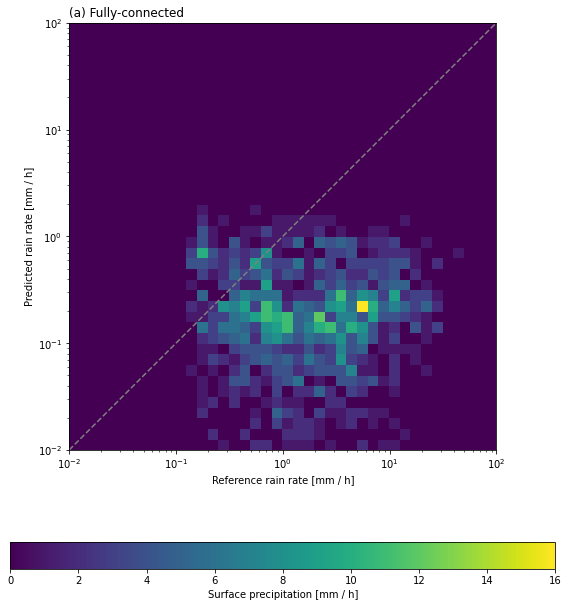

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)
indices = y_val >= 0.0


f, ax = plt.subplots(figsize=(8, 9))


p = ax.pcolormesh(bins, bins, freqs_fc.T, 
              #norm=norm
             )
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
ax.set_title("(a) Fully-connected", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
ax.set_aspect(1.0)


plt.tight_layout()